In [4]:
import pandas as pd
import numpy as np
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
df = pd.read_csv('/content/cellula_toxic_data.csv')
print("Data loaded successfully!")
df.head()

Data loaded successfully!


,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


In [7]:
df["text"] = df["query"] + " " + df["image descriptions"]
df = df.drop(['query', 'image descriptions'], axis=1)

In [8]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["Toxic Category"])
df = df.drop('Toxic Category', axis=1)

In [9]:
num_classes = df["label"].nunique()
print(f"Number of classes: {num_classes}")
print("Label distribution:")
df.label.value_counts()

Number of classes: 9
Label distribution:


,count
label,
3,995
7,792
2,301
8,274
6,196
4,115
5,114
1,110
0,103


In [10]:
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
vocab_size = 5000
max_len = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

In [12]:
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [13]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"Class weights:\n{class_weights}")

Class weights:
{0: np.float64(3.252032520325203), 1: np.float64(3.0303030303030303), 2: np.float64(1.1065006915629323), 3: np.float64(0.33500837520938026), 4: np.float64(2.898550724637681), 5: np.float64(2.93040293040293), 6: np.float64(1.6985138004246285), 7: np.float64(0.4206098843322818), 8: np.float64(1.21765601217656)}


In [14]:
vocab_size = 5000
embedding_dim = 128

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_shape=(max_len,)
    ),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n=== Model Summary ===")
model.summary()


=== Model Summary ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,681 (4.08 MB)

 Trainable params: 1,068,681 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)


In [17]:
history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=25,
    batch_size=32,
    class_weight=class_weights,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.2431 - loss: 2.0211 - val_accuracy: 0.7817 - val_loss: 0.8692 - learning_rate: 0.0010
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7873 - loss: 0.8804 - val_accuracy: 0.8817 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9195 - loss: 0.2693 - val_accuracy: 0.9517 - val_loss: 0.2224 - learning_rate: 0.0010
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9554 - loss: 0.1820 - val_accuracy: 0.9433 - val_loss: 0.2048 - learning_rate: 0.0010
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9736 - loss: 0.1123 - val_accuracy: 0.9183 - val_loss: 0.2368 - learning_rate: 0.0010
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9566 - loss: 0.1659 - val_accuracy: 0.8917 - val_loss: 0.4299 - learning_rate: 0.0010
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9344 - loss: 0.3341 - val_ac

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step

Macro F1 Score: 0.9324

                           precision    recall  f1-score   support

Child Sexual Exploitation       0.84      1.00      0.91        21
                Elections       1.00      1.00      1.00        22
       Non-Violent Crimes       1.00      1.00      1.00        60
                     Safe       0.91      0.94      0.92       199
       Sex-Related Crimes       0.96      1.00      0.98        23
      Suicide & Self-Harm       1.00      1.00      1.00        23
           Unknown S-Type       0.79      0.49      0.60        39
           Violent Crimes       1.00      1.00      1.00       158
                   unsafe       0.95      1.00      0.97        55

                 accuracy                           0.95       600
                macro avg       0.94      0.94      0.93       600
             weighted avg       0.94      0.95      0.94       600



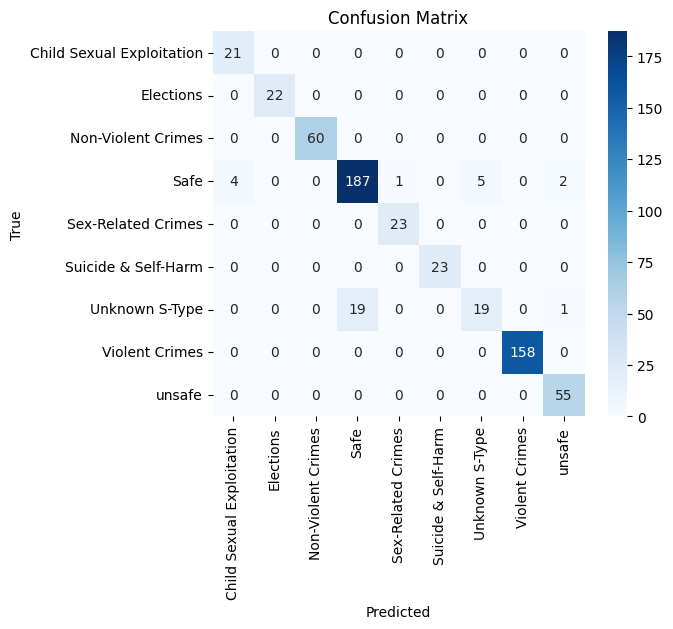

In [18]:
y_pred_probs = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test.values

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average="macro")
print(f"\nMacro F1 Score: {f1:.4f}\n")

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

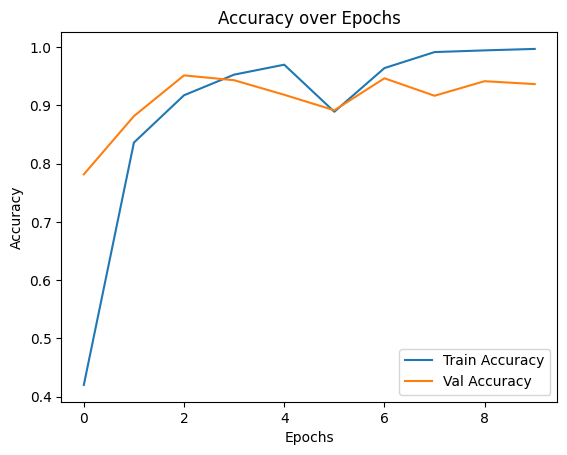

In [19]:
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()


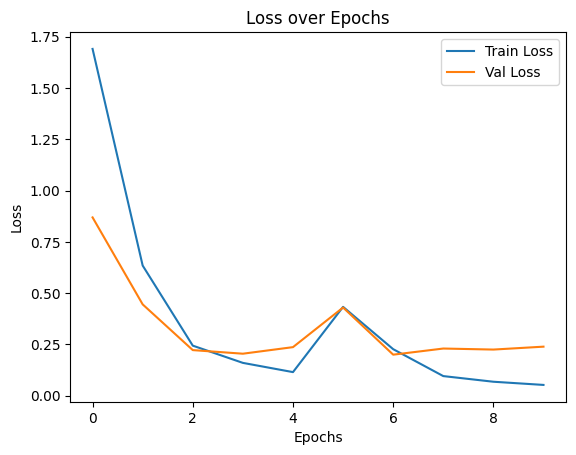

In [20]:
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

In [24]:
model.save("toxic_lstm_model.keras")

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("\nModel, tokenizer, and label encoder saved successfully!")



Model, tokenizer, and label encoder saved successfully!


In [25]:
def predict_text(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding="post")
    pred = model.predict(padded)
    label = le.inverse_transform([pred.argmax()])
    return label[0], pred.max()

In [26]:
test_text = "How do terrorist organizations fund attacks? Police tape at night"
pred_label, confidence = predict_text(test_text)
print(f"\nTest text: {test_text}")
print(f"Predicted category: {pred_label}")
print(f"Confidence: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Test text: How do terrorist organizations fund attacks? Police tape at night
Predicted category: Violent Crimes
Confidence: 0.9727
